In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import glob
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 1000)
pd.set_option('max_rows', 1000)
import warnings
warnings.filterwarnings('ignore')
import gc

import rasterio as rio
import folium
import tifffile as tiff

from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing

# Global Power Plant Database

In [2]:
gpp_df = pd.read_csv('https://raw.githubusercontent.com/wri/global-power-plant-database/master/source_databases_csv/database_IND.csv')
gpp_df.head()

,system:index,capacity_mw,commissioning_year,country,country_long,estimated_generation_gwh,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,geolocation_source,gppd_idnr,name,other_fuel1,other_fuel2,other_fuel3,owner,primary_fuel,source,url,wepp_id,year_of_capacity_data,.geo
0,0000000000000000315a,15.0,1942.0,USA,United States of America,685.397712,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026827,Dos Bocas,NaN,NaN,NaN,PREPA,Hydro,CEPR,http://energia.pr.gov/datos/plantas/,30936.0,0,"{""type"":""Point"",""coordinates"":[-66.66629863706..."
1,000000000000000026e5,1492.0,1975.0,USA,United States of America,8334.010812,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026809,Aguirre,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/aguirre.asp,30928.0,0,"{""type"":""Point"",""coordinates"":[-66.23079607357..."
2,00000000000000002fda,990.0,1962.0,USA,United States of America,5529.940150,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026811,Costa Sur,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/costasur.asp,30934.0,0,"{""type"":""Point"",""coordinates"":[-66.75340271704..."
3,00000000000000003f76,602.0,1960.0,USA,United States of America,3362.650475,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026814,Palo Seco,NaN,NaN,NaN,PREPA,Oil,PREPA,http://www.prepa.com/PALOSECO.ASP,30942.0,0,"{""type"":""Point"",""coordinates"":[-66.14859700475..."
4,00000000000000002def,10.0,1915.0,USA,United States of America,456.931808,0.0,0.0,0.0,0.0,0.0,WRI,WRI1026821,Carite 1,NaN,NaN,NaN,PREPA,Hydro,PREPA,http://www.prepa.com/historia_eng.asp https:/...,65289.0,0,"{""type"":""Point"",""coordinates"":[-66.10600367149..."


In [3]:
def plot_points_on_map(dataframe,begin_index,end_index,latitude_column,latitude_value,longitude_column,longitude_value,zoom):
    df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.primary_fuel[i:i+1]))
        folium.Marker([df[latitude_column].iloc[i],df[longitude_column].iloc[i]],popup=popup).add_to(plot)
    return(plot)

def overlay_image_on_puerto_rico(file_name,band_layer,lat,lon,zoom):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat, lon], zoom_start=zoom)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m

def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

def split_column_into_new_columns(dataframe,column_to_split,new_column_one,begin_column_one,end_column_one):
    for i in range(0, len(dataframe)):
        dataframe.loc[i, new_column_one] = dataframe.loc[i, column_to_split][begin_column_one:end_column_one]
    return dataframe

In [5]:
years = [2013, 2014, 2015, 2016, 2017]
print([(gpp_df[f'generation_gwh_{x}'].nunique()) for x in years])

[1, 1, 1, 1, 1]


In [6]:
print('There are {} power plants'.format(gpp_df.shape[0]))

There are 35 power plants


In [9]:
gpp_df['commissioning_year'].value_counts()

0.0       21
2012.0     2
1941.0     2
2015.0     1
2011.0     1
2009.0     1
1937.0     1
1929.0     1
1915.0     1
1960.0     1
1962.0     1
1975.0     1
1942.0     1
Name: commissioning_year, dtype: int64

In [11]:
gpp_df.groupby(['primary_fuel']).agg({'estimated_generation_gwh': ['nunique', 'sum', 'mean', 'max', 'min'], 'capacity_mw' : ['nunique', 'sum', 'mean', 'max', 'min']}).reset_index()

primary_fuel estimated_generation_gwh                                \
                                nunique            sum           mean   
0         Coal                        1  450562.692350  450562.692350   
1          Gas                        4    7785.243454     865.027050   
2        Hydro                       11    4953.140798     450.285527   
3          Oil                        6   23468.730848    3911.455141   
4        Solar                        6      68.962714      11.493786   
5         Wind                        2      22.104981      11.052491   

                                capacity_mw                           \
             max            min     nunique          sum        mean   
0  450562.692350  450562.692350           1   454.299988  454.299988   
1    3572.052879     295.909706           4  1105.000000  122.777778   
2    1142.329520      87.730907          11   108.400000    9.854545   
3    8334.010812      33.514789           6  4201.500000  700.250000   
4      25.707730       2.006675           6   154.650002   25.775000   
5      17.953645       4.151337           2   124.599997   62.299998   

                            
           max         min  
0   454.299988  454.299988  
1   507.000000   42.000000  
2    25.000000    1.920000  
3  1492.000000    6.000000  
4    57.650002    4.500000  
5   101.199997   23.400000

In [12]:
df = gpp_df[['name','latitude','longitude','primary_fuel','capacity_mw','estimated_generation_gwh', 'owner']].sort_values('estimated_generation_gwh', ascending = False)
df.head()

,name,latitude,longitude,primary_fuel,capacity_mw,estimated_generation_gwh,owner
28,A.E.S. Corp.,17.947400,-66.1493996429472,Coal,454.299988,450562.692350,AES Corporation
1,Aguirre,17.951899,-66.2307960735768,Oil,1492.000000,8334.010812,PREPA
2,Costa Sur,18.000298,-66.7534027170407,Oil,990.000000,5529.940150,PREPA
30,San Juan CC,18.426999,-66.1045009544401,Oil,864.000000,4826.129585,PREPA
14,EcoEléctrica,17.981200,-66.7552041938662,Gas,507.000000,3572.052879,Gas Natural Fenosa International Power


In [19]:
p_fuel_types = ['Coal', 'Oil', 'Gas']
# only consider pollute fuel types
p_type_df = gpp_df[gpp_df['primary_fuel'].isin(p_fuel_types)]
# sum the electricity generation
p_type_sum = p_type_df['estimated_generation_gwh'].sum()
# sum the pollution of the last satellite picture
sum_no2_emission = np.sum(tiff.imread(image)[:, :, 0 : 4])
# consider 14% of pollution is made from power plants electricity
sum_no2_emission_oe = sum_no2_emission * 0.14
# use the simplified emission factor formula
factor = sum_no2_emission_oe / p_type_sum
print(f'Simplified emissions factor for Puerto Rico is {factor} mol * h / m^2 * gw')

Simplified emissions factor for Puerto Rico is 5.962452842460552e-06 mol * h / m^2 * gw


# What could be wrong with this simple methology:

* Remember that the model needs to reproduce an annual average historical grid-level electricity emissions factor (based on rolling 12-months of data from July 2018 - July 2019) for Puerto Rico.

* Pictures are different each day, meaning that using only one picture makes no sense at all.

* Consider 14% of pollution is made from power plants electricity? This is a general stat, we should some how use the information given in the power plant database to estimate better. I believe that fuel type and commissioning_year is a very important factor to consider. In other words a really important objective is to calculate the % of pollution made from Puerto Rico power plants!!!.

* Another important factor is to check each plant. Does all plants in Puerto Rico pollute?

Let's try and make better and more accurate baseline factor using all the NO2 emission pictures that we have!!

In [20]:
no2_path = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/*'
no2_pictures_path = glob.glob(no2_path)
len(no2_pictures_path)
print('We have {} pictures of the Copernicus Sentinel'.format(len(no2_pictures_path)))

We have 387 pictures of the Copernicus Sentinel


Let's preprocess this data.

In [21]:
# this function will help us extract the no2 emission data in a tabular way
def read_s5p_no2_pictures_data(only_no2_emissions = True):
    s5p_no2_pictures = []
    for num, i in tqdm(enumerate(no2_pictures_path), total = 387):
        temp_s5p_no2_pictures = {'start_date': [], 'end_date': [], 'data': []}
        temp_s5p_no2_pictures['start_date'] = no2_pictures_path[num][76:84]
        temp_s5p_no2_pictures['end_date'] = no2_pictures_path[num][92:100]
        # only no2 emissions
        if only_no2_emissions:
            temp_s5p_no2_pictures['data'] = tiff.imread(i)[:, :, 0 : 4]
            temp_s5p_no2_pictures['no2_emission_sum'] = np.sum(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_mean'] = np.average(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_std'] = np.std(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_max'] = np.max(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_min'] = np.min(tiff.imread(i)[:, :, 0 : 4])
            s5p_no2_pictures.append(temp_s5p_no2_pictures)
        # all Copernicus data
        else:
            temp_s5p_no2_pictures['data'] = tiff.imread(i)
            s5p_no2_pictures.append(temp_s5p_no2_pictures)
    s5p_no2_pictures = pd.DataFrame(s5p_no2_pictures)
    s5p_no2_pictures['start_date'] = pd.to_datetime(s5p_no2_pictures['start_date'])
    s5p_no2_pictures['end_date'] = pd.to_datetime(s5p_no2_pictures['end_date'])
    s5p_no2_pictures.sort_values('start_date', inplace = True)
    s5p_no2_pictures.reset_index(drop = True, inplace = True)
    return s5p_no2_pictures

s5p_no2_pictures_df = read_s5p_no2_pictures_data()

# NO2 Analysis

For speed purpose we are going to split the data in 2 dataframes

In [22]:
s5p_no2_pictures_stats = s5p_no2_pictures_df[[col for col in s5p_no2_pictures_df.columns if col not in ['data']]]
s5p_no2_pictures_data = s5p_no2_pictures_df[['data']]
del s5p_no2_pictures_df
s5p_no2_pictures_stats.head()

,start_date,end_date,no2_emission_sum,no2_emission_mean,no2_emission_std,no2_emission_max,no2_emission_min
0,2018-07-01,2018-07-07,18.923768,0.000067,0.000053,0.000196,-4.054218e-07
1,2018-07-02,2018-07-08,18.560087,0.000066,0.000053,0.000186,-2.843851e-06
2,2018-07-04,2018-07-10,16.176976,0.000058,0.000037,0.000141,-3.731904e-06
3,2018-07-05,2018-07-12,16.301243,0.000058,0.000039,0.000180,-8.590432e-06
4,2018-07-06,2018-07-12,NaN,NaN,NaN,NaN,NaN


There most common range between dates is 6 days.

We have some negatives values, is that correct?

MMMMMM we have some rows were the sum of NO2 emission is NaN. Let's check why

In [23]:
def check_arrays(df, row = 1):
    band1 = pd.DataFrame(s5p_no2_pictures_data['data'][row][:, :, 0])
    band2 = pd.DataFrame(s5p_no2_pictures_data['data'][row][:, :, 1])
    band3 = pd.DataFrame(s5p_no2_pictures_data['data'][row][:, :, 2])
    band4 = pd.DataFrame(s5p_no2_pictures_data['data'][row][:, :, 3])
    
    def check_nan(df):
        df_nan = df.isnull().values.sum()
        return df_nan
    
    band1_nan = check_nan(band1)
    band2_nan = check_nan(band2)
    band3_nan = check_nan(band3)
    band4_nan = check_nan(band4)
    
    print('From row {} we have {} nan values for band1'.format(row, band1_nan))
    print('From row {} we have {} nan values for band2'.format(row, band2_nan))
    print('From row {} we have {} nan values for band3'.format(row, band3_nan))
    print('From row {} we have {} nan values for band4'.format(row, band4_nan))

    return band1, band2, band3, band4

band1, band2, band3, band4 = check_arrays(s5p_no2_pictures_data, row = 4)

From row 4 we have 517 nan values for band1
From row 4 we have 517 nan values for band2
From row 4 we have 517 nan values for band3
From row 4 we have 517 nan values for band4


We have some nan values in our images. 

* Why do we have some nan values in our images? 
* Should we impute these values for better data quality or ignore them??

Lets ignore them for know, going to leave them in my backlog :)

In [24]:
# this function ignore nan values from the images
def read_s5p_no2_pictures_data_ignore_nan(only_no2_emissions = True):
    s5p_no2_pictures = []
    for num, i in tqdm(enumerate(no2_pictures_path), total = 387):
        temp_s5p_no2_pictures = {'start_date': [], 'end_date': [], 'data': []}
        temp_s5p_no2_pictures['start_date'] = no2_pictures_path[num][76:84]
        temp_s5p_no2_pictures['end_date'] = no2_pictures_path[num][92:100]
        # only no2 emissions
        if only_no2_emissions:
            temp_s5p_no2_pictures['data'] = tiff.imread(i)[:, :, 0 : 4]
            temp_s5p_no2_pictures['no2_emission_sum'] = np.nansum(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_mean'] = np.nanmean(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_std'] = np.nanstd(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_max'] = np.nanmax(tiff.imread(i)[:, :, 0 : 4])
            temp_s5p_no2_pictures['no2_emission_min'] = np.nanmin(tiff.imread(i)[:, :, 0 : 4])
            s5p_no2_pictures.append(temp_s5p_no2_pictures)
        # all Copernicus data
        else:
            temp_s5p_no2_pictures['data'] = tiff.imread(i)
            s5p_no2_pictures.append(temp_s5p_no2_pictures)
    s5p_no2_pictures = pd.DataFrame(s5p_no2_pictures)
    s5p_no2_pictures['start_date'] = pd.to_datetime(s5p_no2_pictures['start_date'])
    s5p_no2_pictures['end_date'] = pd.to_datetime(s5p_no2_pictures['end_date'])
    s5p_no2_pictures.sort_values('start_date', inplace = True)
    s5p_no2_pictures.reset_index(drop = True, inplace = True)
    return s5p_no2_pictures

s5p_no2_pictures_df_ig_nan = read_s5p_no2_pictures_data_ignore_nan()

In [25]:
s5p_no2_pictures_stats_ig_nan = s5p_no2_pictures_df_ig_nan[[col for col in s5p_no2_pictures_df_ig_nan.columns if col not in ['data']]]
del s5p_no2_pictures_df_ig_nan
s5p_no2_pictures_stats_ig_nan.head()

,start_date,end_date,no2_emission_sum,no2_emission_mean,no2_emission_std,no2_emission_max,no2_emission_min
0,2018-07-01,2018-07-07,18.923768,0.000067,0.000053,0.000196,-4.054218e-07
1,2018-07-02,2018-07-08,18.560087,0.000066,0.000053,0.000186,-2.843851e-06
2,2018-07-04,2018-07-10,16.176976,0.000058,0.000037,0.000141,-3.731904e-06
3,2018-07-05,2018-07-12,16.301243,0.000058,0.000039,0.000180,-8.590432e-06
4,2018-07-06,2018-07-12,17.583602,0.000063,0.000049,0.000178,-4.465832e-06


Now we have a time series dataframe!!. Let's make some plots to visualize the information

* We have information of NO2 emission between 2018-07-01 and 2019-06-29
* We can see a lot of peaks, is there a reasonable explanation for this low values? Maybee ignoring nan values is not correct.
* Why do we have 387 observations? A year have 365 days
* We have some duplicate dates

Can we use only the values of the previous graph for our factor?, i think we cant because we are loosing too much information. We need to find a way to deal with this

In [29]:
n_duplicates_dates = s5p_no2_pictures_stats_ig_nan.shape[0] - s5p_no2_pictures_stats_ig_nan.drop_duplicates(subset = ['start_date', 'end_date']).shape[0]
print(f'We have {n_duplicates_dates} duplicate days')

We have 42 duplicate days


* Why do we have duplicate days?
* What should we do with this days?

Let's interpolate the nan values!!!

In [30]:
# this function will help us extract the no2 emission data in a tabular way
def read_s5p_no2_pictures_data_fill(only_no2_emissions = True):
    s5p_no2_pictures = []
    for num, i in tqdm(enumerate(no2_pictures_path), total = 387):
        temp_s5p_no2_pictures = {'start_date': [], 'end_date': [], 'data': []}
        temp_s5p_no2_pictures['start_date'] = no2_pictures_path[num][76:84]
        temp_s5p_no2_pictures['end_date'] = no2_pictures_path[num][92:100]
        # only no2 emissions
        if only_no2_emissions:
            image = tiff.imread(i)[:, :, 0 : 4]
            band1 = pd.DataFrame(image[: ,: , 0]).interpolate()
            band1.fillna(band1.mean(), inplace = True)
            band2 = pd.DataFrame(image[: ,: , 1]).interpolate()
            band2.fillna(band2.mean(), inplace = True)
            band3 = pd.DataFrame(image[: ,: , 2]).interpolate()
            band3.fillna(band3.mean(), inplace = True)
            band4 = pd.DataFrame(image[: ,: , 3]).interpolate()
            band4.fillna(band4.mean(), inplace = True)
            image = np.dstack((band1, band2, band3, band4))
            temp_s5p_no2_pictures['data'] = image
            temp_s5p_no2_pictures['no2_emission_sum'] = np.sum(image)
            temp_s5p_no2_pictures['no2_emission_mean'] = np.average(image)
            temp_s5p_no2_pictures['no2_emission_std'] = np.std(image)
            temp_s5p_no2_pictures['no2_emission_max'] = np.max(image)
            temp_s5p_no2_pictures['no2_emission_min'] = np.min(image)
            s5p_no2_pictures.append(temp_s5p_no2_pictures)
        # all Copernicus data
        else:
            temp_s5p_no2_pictures['data'] = tiff.imread(i)
            s5p_no2_pictures.append(temp_s5p_no2_pictures)
    s5p_no2_pictures = pd.DataFrame(s5p_no2_pictures)
    s5p_no2_pictures['start_date'] = pd.to_datetime(s5p_no2_pictures['start_date'])
    s5p_no2_pictures['end_date'] = pd.to_datetime(s5p_no2_pictures['end_date'])
    s5p_no2_pictures.sort_values('start_date', inplace = True)
    s5p_no2_pictures.reset_index(drop = True, inplace = True)
    return s5p_no2_pictures

s5p_no2_pictures_df_fill = read_s5p_no2_pictures_data_fill()

In [31]:
s5p_no2_pictures_stats_fill = s5p_no2_pictures_df_fill[[col for col in s5p_no2_pictures_df_fill.columns if col not in ['data']]]
del s5p_no2_pictures_df_fill
s5p_no2_pictures_stats_fill.head()

,start_date,end_date,no2_emission_sum,no2_emission_mean,no2_emission_std,no2_emission_max,no2_emission_min
0,2018-07-01,2018-07-07,18.923768,0.000067,0.000053,0.000196,-4.054218e-07
1,2018-07-02,2018-07-08,18.560087,0.000066,0.000053,0.000186,-2.843851e-06
2,2018-07-04,2018-07-10,16.176976,0.000058,0.000037,0.000141,-3.731904e-06
3,2018-07-05,2018-07-12,16.301243,0.000058,0.000039,0.000180,-8.590432e-06
4,2018-07-06,2018-07-12,17.714418,0.000063,0.000049,0.000178,-4.465832e-06


In [32]:
# drop nan values and check again for duplicate columns
s5p_no2_pictures_stats_fill = s5p_no2_pictures_stats_fill[s5p_no2_pictures_stats_fill['start_date']!='2019-04-15'].dropna()
# drop 2019-04-15 (probably an outlier or a rare event that can affect our factor calculation)
duplicate_columns = s5p_no2_pictures_stats_fill.shape[0] - s5p_no2_pictures_stats_fill.drop_duplicates(subset = ['start_date', 'end_date']).shape[0]
print(f'We have {duplicate_columns} duplicate columns')
print('We have {} days of data'.format(s5p_no2_pictures_stats_fill['start_date'].nunique()))

We have 0 duplicate columns
We have 338 days of data


Great! we have clean our NO2 dataset. Let's plot it again.

* We have a nice and stable curve
* Between August 13 of 2018 and March 9 of 2019  we can see a decrease in NO2 emissions (lower trend)
* What can we do with the missing days? Can we predict them with an arima model?

Now that we have better NO2 information, let's calculate again the factor using the simple methodology

In [34]:
# get the mean NO2 emission between 2018/07/01 and 2019/06/29
sum_no2_emission = s5p_no2_pictures_stats_fill['no2_emission_sum'].mean()
# consider 14% of pollution is made from power plants electricity
sum_no2_emission_oe = sum_no2_emission * 0.14
# use the simplified emission factor formula (sum of estimated generation from Caol, Oil and Gas plants)
factor = sum_no2_emission_oe / p_type_sum
print(f'Simplified emissions factor for Puerto Rico is {factor} mol * h / m^2 * gw')

Simplified emissions factor for Puerto Rico is 4.643152098709246e-06 mol * h / m^2 * gw


Our factor changed a lot!!!.

Let's see how we can add more variable to the equation. Let's continue with the weather data!!

In [35]:
weather_path = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/gfs/*'
weather_pictures_path = glob.glob(weather_path)
len(weather_pictures_path)
print('We have {} pictures of the global forecast system'.format(len(weather_pictures_path)))

We have 1460 pictures of the global forecast system


* We have more than one photo for each day. Probably the last 2 digits before .tif is the hour

In [36]:
tiff.imread(weather_pictures_path[0]).shape

(148, 475, 6)

* Can only see 6 bands in this image. We are going to assume that their are the first 6 bands (plz correct me if i am wrong)

In [37]:
# this function will help us extract weather pictures in a tabular way
def read_weather_data():
    weather_pictures = []
    for num, i in tqdm(enumerate(weather_pictures_path), total = len(weather_pictures_path)):
        temp_weather_pictures = {'date': [], 'temperature_2m_above_ground': [], 'specific_humidity_2m_above_ground': [], 'relative_humidity_2m_above_ground': [], 
                                 'u_component_of_wind_10m_above_ground': [], 'v_component_of_wind_10m_above_ground': [], 'total_precipitation_surface': []}
        temp_weather_pictures['date'] = weather_pictures_path[num][68:-6]
        temp_weather_pictures['date'] = weather_pictures_path[num][68:-6]
        image = tiff.imread(i)
        temp_weather_pictures['temperature_2m_above_ground'] = image[ : , : , 0]
        temp_weather_pictures['specific_humidity_2m_above_ground'] = image[ : , : , 1]
        temp_weather_pictures['relative_humidity_2m_above_ground'] = image[ : , : , 2]
        temp_weather_pictures['u_component_of_wind_10m_above_ground'] = image[ : , : , 3]
        temp_weather_pictures['v_component_of_wind_10m_above_ground'] = image[ : , : , 4]
        temp_weather_pictures['total_precipitation_surface'] = image[ : , : , 5]
        temp_weather_pictures['temperature_2m_above_ground_mean'] = np.average(image[ : , : , 0])
        temp_weather_pictures['specific_humidity_2m_above_ground_mean'] = np.average(image[ : , : , 1])
        temp_weather_pictures['relative_humidity_2m_above_ground_mean'] = np.average(image[ : , : , 2])
        temp_weather_pictures['u_component_of_wind_10m_above_ground_mean'] = np.average(image[ : , : , 3])
        temp_weather_pictures['v_component_of_wind_10m_above_ground_mean'] = np.average(image[ : , : , 4])
        temp_weather_pictures['total_precipitation_surface_mean'] = np.average(image[ : , : , 5])
        
        weather_pictures.append(temp_weather_pictures)
    
    weather_pictures = pd.DataFrame(weather_pictures)
    weather_pictures['date'] = pd.to_datetime(weather_pictures['date'], infer_datetime_format  = True)
    weather_pictures.sort_values('date', inplace = True)
    weather_pictures.reset_index(drop = True, inplace = True)
    return weather_pictures

weather_pictures_df = read_weather_data()

In [38]:
weather_pictures_df.head()

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,total_precipitation_surface,temperature_2m_above_ground_mean,specific_humidity_2m_above_ground_mean,relative_humidity_2m_above_ground_mean,u_component_of_wind_10m_above_ground_mean,v_component_of_wind_10m_above_ground_mean,total_precipitation_surface_mean
0,2018-07-01,"[[27.319757080078148, 27.319757080078148, 27.3...","[[0.01800999976694584, 0.01800999976694584, 0....","[[79.80000305175781, 79.80000305175781, 79.800...","[[-8.028334617614746, -8.028334617614746, -8.0...","[[-2.408210277557373, -2.408210277557373, -2.4...","[[36.065364837646484, 36.065364837646484, 36.0...",25.825862,0.016881,81.037281,-3.423931,-1.518467,32.592481
1,2018-07-01,"[[26.650018310546898, 26.650018310546898, 26.6...","[[0.01647000014781952, 0.01647000014781952, 0....","[[75.80000305175781, 75.80000305175781, 75.800...","[[-5.701642990112305, -5.701642990112305, -5.7...","[[-1.1736425161361694, -1.1736425161361694, -1...","[[29.100000381469727, 29.100000381469727, 29.1...",26.721326,0.015933,72.501199,-3.198577,-1.064460,29.777113
2,2018-07-01,"[[27.650018310546898, 27.650018310546898, 27.6...","[[0.01793999969959259, 0.01793999969959259, 0....","[[77.82247924804688, 77.82247924804688, 77.822...","[[-5.73009729385376, -5.73009729385376, -5.730...","[[-6.115441799163818, -6.115441799163818, -6.1...","[[35.10000228881836, 35.10000228881836, 35.100...",29.591174,0.016797,65.249798,-4.041724,-0.803598,33.662348
3,2018-07-01,"[[26.550012207031273, 26.550012207031273, 26.5...","[[0.017090000212192535, 0.017090000212192535, ...","[[79.4000015258789, 79.4000015258789, 79.40000...","[[-6.701745510101318, -6.701745510101318, -6.7...","[[-1.2836816310882568, -1.2836816310882568, -1...","[[31.700000762939453, 31.700000762939453, 31.7...",24.654592,0.015828,81.975105,-3.046369,-0.986729,30.464020
4,2018-07-02,"[[27.038964843750023, 27.038964843750023, 27.0...","[[0.018069999292492867, 0.018069999292492867, ...","[[81.5, 81.5, 81.5, 81.5, 81.5, 81.5, 81.5, 81...","[[-7.756444931030273, -7.756444931030273, -7.7...","[[-2.424609422683716, -2.424609422683716, -2.4...","[[37.20000076293945, 37.20000076293945, 37.200...",25.821642,0.017302,82.992838,-3.458926,-1.000598,33.521104


In [39]:
# check missing values
img_columns = ['temperature_2m_above_ground', 'specific_humidity_2m_above_ground', 'relative_humidity_2m_above_ground', 
               'u_component_of_wind_10m_above_ground', 'v_component_of_wind_10m_above_ground', 'total_precipitation_surface']
weather_pictures_df[[col for col in weather_pictures_df.columns if col not in img_columns]].isnull().sum()

date                                         0
temperature_2m_above_ground_mean             0
specific_humidity_2m_above_ground_mean       0
relative_humidity_2m_above_ground_mean       0
u_component_of_wind_10m_above_ground_mean    0
v_component_of_wind_10m_above_ground_mean    0
total_precipitation_surface_mean             0
dtype: int64

Weather image dont have missing values, great!

In [40]:
weather_pictures_df_stats = weather_pictures_df[[col for col in weather_pictures_df.columns if col not in img_columns]]
n_duplicates = weather_pictures_df_stats.shape[0] - weather_pictures_df_stats['date'].nunique()
print(f'We have {n_duplicates} observations that belongs to a date with one or more records')

We have 1095 observations that belongs to a date with one or more records


Let's get the mean to have one observation for each day. Then let's plot them and check the graphs

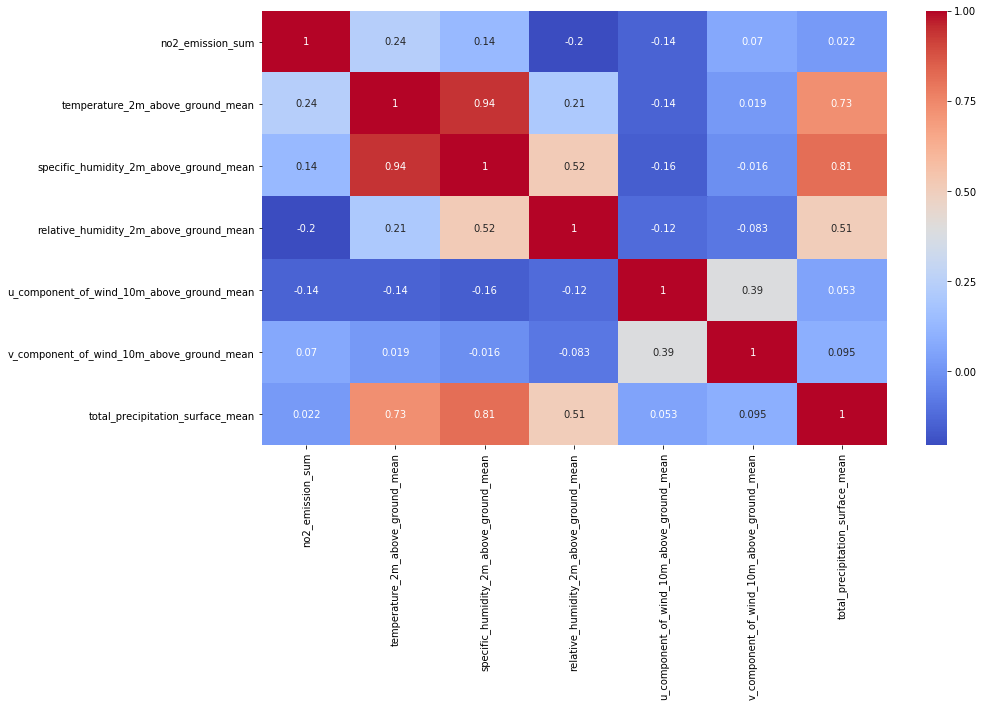

In [48]:
plt.figure(figsize = (14, 8))
sns.heatmap(no2_weather.corr(), annot = True, cmap = 'coolwarm')

Temperature and relative humidity are the most correlated features with N02

Training and evaluatin fold 0
Our rmse for month 5 is 1.52066477204412
Training and evaluatin fold 1
Our rmse for month 11 is 1.5262711192997904
Training and evaluatin fold 2
Our rmse for month 9 is 1.0382634390279457
Training and evaluatin fold 3
Our rmse for month 3 is 1.5829574995869464
Training and evaluatin fold 4
Our rmse for month 12 is 1.5041194625127656
Training and evaluatin fold 5
Our rmse for month 10 is 1.2556155200638937
Training and evaluatin fold 6
Our rmse for month 1 is 1.3195830585639758
Training and evaluatin fold 7
Our rmse for month 8 is 1.1228135811887334
Training and evaluatin fold 8
Our rmse for month 4 is 1.6717426779405125
Training and evaluatin fold 9
Our rmse for month 2 is 1.084108367996543
Training and evaluatin fold 10
Our rmse for month 7 is 1.3781209628813635
Training and evaluatin fold 11
Our rmse for month 6 is 1.8425557202452332


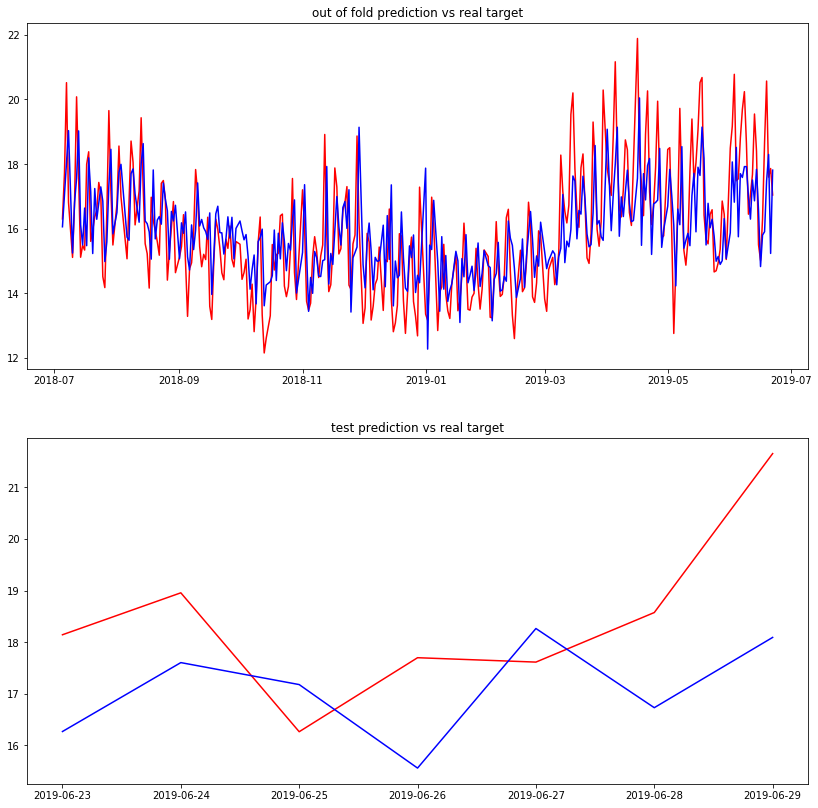

The standard deviation for no2 emissions for each month is:
    month  no2_emission_sum
0       1          1.034956
1       2          1.154565
2       3          1.854444
3       4          1.602731
4       5          1.923545
5       6          1.551396
6       7          1.643600
7       8          1.338508
8       9          1.009857
9      10          1.281042
10     11          1.461280
11     12          1.267867
Our out of folds rmse is 1.4177970436594391
Our test rmse is 1.9739140803544308


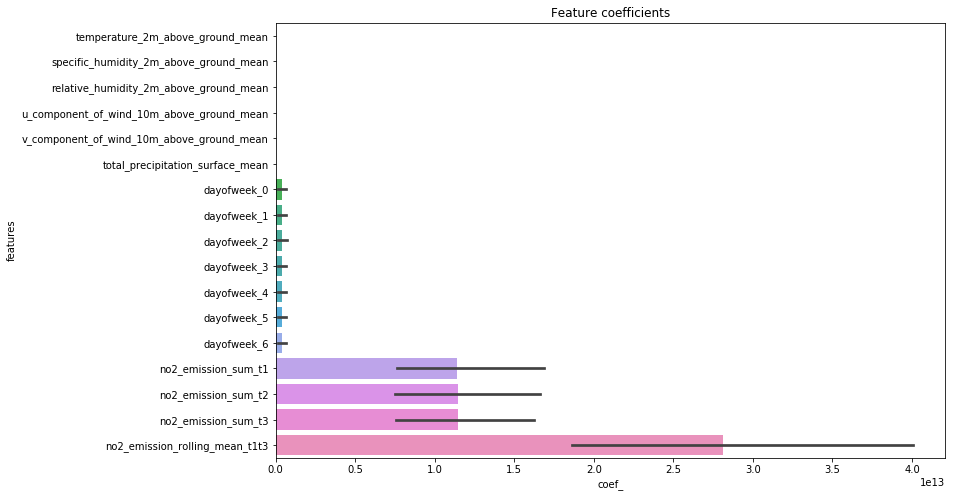

In [49]:
def preprocess_data(no2_weather, use_lags = True, use_time = True):
    reg_dataset = no2_weather[['date', 'temperature_2m_above_ground_mean', 'specific_humidity_2m_above_ground_mean', 'relative_humidity_2m_above_ground_mean', 'u_component_of_wind_10m_above_ground_mean', 
                               'v_component_of_wind_10m_above_ground_mean', 'total_precipitation_surface_mean', 'no2_emission_sum']]
    # get month for groupkfold validation
    reg_dataset['month'] = reg_dataset['date'].dt.month
    if use_time:
        # get day of week as feature
        reg_dataset['dayofweek'] = reg_dataset['date'].dt.dayofweek
        # one hot encoder 
        reg_dataset = pd.get_dummies(reg_dataset, columns = ['dayofweek'])
    if use_lags:
        # get no2_emissions lags
        reg_dataset['no2_emission_sum_t1'] = reg_dataset['no2_emission_sum'].shift(1)
        reg_dataset['no2_emission_sum_t2'] = reg_dataset['no2_emission_sum'].shift(2)
        reg_dataset['no2_emission_sum_t3'] = reg_dataset['no2_emission_sum'].shift(3)
        reg_dataset['no2_emission_rolling_mean_t1t3'] = (reg_dataset['no2_emission_sum_t1'] + reg_dataset['no2_emission_sum_t2'] + reg_dataset['no2_emission_sum_t3']) / 3
        # drop nan columns produce by the lags
        reg_dataset.dropna(inplace = True)
    # split train and test
    train = reg_dataset[reg_dataset['date'] < '2019-06-23']
    test = reg_dataset[reg_dataset['date'] >= '2019-06-23']
    features = [col for col in train.columns if col not in ['date', 'no2_emission_sum', 'month']]
    return train, test, features


def train_linear_regression(train, test, features, n_folds = 12):
    # 12 folds, each one representing 1 month
    target = 'no2_emission_sum'
    kfold = GroupKFold(n_folds)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    all_coef = pd.DataFrame()
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train[features], groups = train['month'])):
        print(f'Training and evaluatin fold {fold}')
        x_train, y_train = train[features].iloc[trn_ind], train[target].iloc[trn_ind]
        x_val, y_val = train[features].iloc[val_ind], train[target].iloc[val_ind]
        # standarize train and eval
        scaler = preprocessing.StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_val = scaler.transform(x_val)
        test_scaled = scaler.transform(test[features])
        month = train[['month']].iloc[val_ind]['month'].unique()[0]
        model = LinearRegression().fit(x_train, y_train)
        fold_prediction = model.predict(x_val)
        fold_error = np.sqrt(metrics.mean_squared_error(y_val, fold_prediction))
        print(f'Our rmse for month {month} is {fold_error}')
        oof[val_ind] = fold_prediction
        predictions += model.predict(test_scaled) / n_folds
        coef = pd.DataFrame({'features': train[features].columns})
        coef['coef_'] = model.coef_
        all_coef = pd.concat([all_coef, coef])
    oof_rmse = np.sqrt(metrics.mean_squared_error(train[target], oof))
    test_error = np.sqrt(metrics.mean_squared_error(test[target], predictions))
    fig, ax = plt.subplots(2, 1, figsize = (14, 14))
    ax[0].plot(train['date'], train[target], color = 'red', label = 'real')
    ax[0].plot(train['date'], oof, color = 'blue', label = 'prediction')
    ax[0].set_title('out of fold prediction vs real target')
    ax[1].plot(test['date'], test[target], color = 'red', label = 'real')
    ax[1].plot(test['date'], predictions, color = 'blue', label = 'prediction')
    ax[1].set_title('test prediction vs real target')
    plt.show()
    print('The standard deviation for no2 emissions for each month is:')
    print(train.groupby('month')[target].std().reset_index())
    print(f'Our out of folds rmse is {oof_rmse}')
    print(f'Our test rmse is {test_error}')
    return oof, predictions, all_coef

def plot_coef(coef):
    plt.figure(figsize = (12, 8))
    # absolute for better visuals
    sns.barplot(abs(coef['coef_']), coef['features'], orient = 'h')
    plt.title('Feature coefficients')
    plt.show()

# train with lags and time features
train1, test1, features1 = preprocess_data(no2_weather, use_lags = True, use_time = True)
oof1, predictions1, all_coef1 = train_linear_regression(train1, test1, features1, n_folds = 12)
plot_coef(all_coef1)

* There are some months that are hardest to predict.
* Lags are the most important features

Training and evaluatin fold 0
Our rmse for month 5 is 2.1541955163966287
Training and evaluatin fold 1
Our rmse for month 11 is 1.4887550677221861
Training and evaluatin fold 2
Our rmse for month 9 is 1.7457674337571507
Training and evaluatin fold 3
Our rmse for month 3 is 2.3515562019401983
Training and evaluatin fold 4
Our rmse for month 12 is 2.162184835146548
Training and evaluatin fold 5
Our rmse for month 10 is 2.0978373273636324
Training and evaluatin fold 6
Our rmse for month 7 is 1.5604749009513026
Training and evaluatin fold 7
Our rmse for month 1 is 1.3280786579955821
Training and evaluatin fold 8
Our rmse for month 8 is 1.2563110192359537
Training and evaluatin fold 9
Our rmse for month 4 is 2.4371784079882604
Training and evaluatin fold 10
Our rmse for month 2 is 1.5778143883366589
Training and evaluatin fold 11
Our rmse for month 6 is 2.8555062049334548


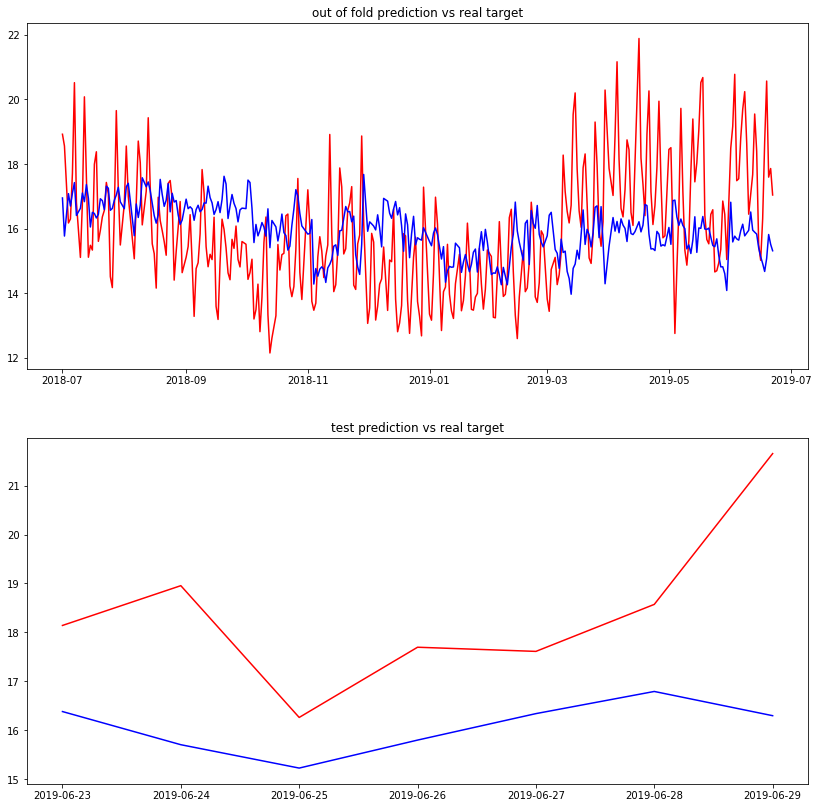

The standard deviation for no2 emissions for each month is:
    month  no2_emission_sum
0       1          1.034956
1       2          1.154565
2       3          1.854444
3       4          1.602731
4       5          1.923545
5       6          1.551396
6       7          1.638645
7       8          1.338508
8       9          1.009857
9      10          1.281042
10     11          1.461280
11     12          1.267867
Our out of folds rmse is 1.9595910389819762
Our test rmse is 2.719640421869412


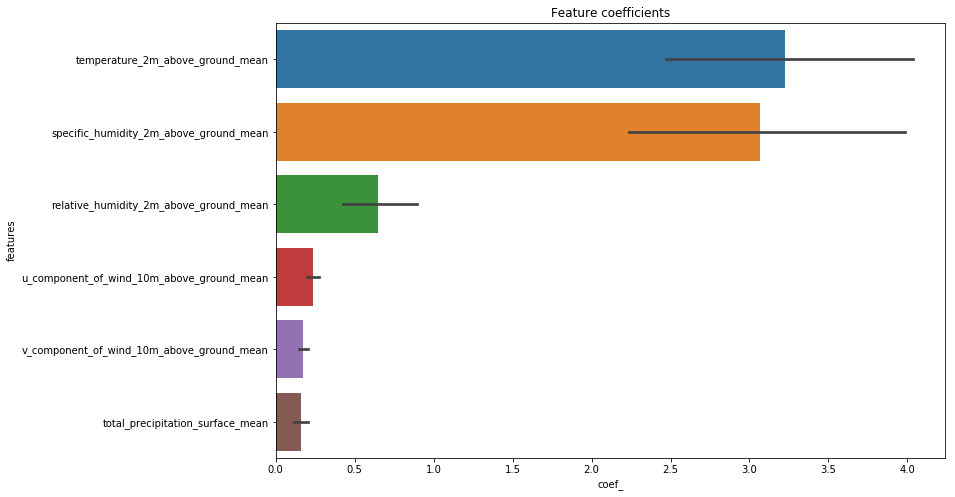

In [50]:
train2, test2, features2 = preprocess_data(no2_weather, use_lags = False, use_time = False)
oof2, predictions2, all_coef2 = train_linear_regression(train2, test2, features2, n_folds = 12)
plot_coef(all_coef2)